In [1]:
# Lazım olan kitabxanalar
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import set_config

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle

In [2]:
sns.set(font_scale = 1.5, style = 'darkgrid', palette = 'bright')
warnings.filterwarnings(action = 'ignore')
plt.rcParams['figure.figsize'] = (12, 8)
pd.options.display.max_columns = None
set_config(display = 'diagram')
np.random.seed(seed = 42)

In [3]:
# load_data adında funksiyanın yaradılması
def load_data(filepath = None, non_na_ratio = None):
    # Datasetin yüklənməsi
    data_frame = pd.read_csv(filepath_or_buffer = filepath)
    
    # Dublikat dəyərlərin silinməsi
    data_frame.drop_duplicates(inplace = True, ignore_index = True)
    
    # 40% çox boş xanası olan sütunların silinməsi
    data_frame.dropna(axis = 1, thresh = int(data_frame.shape[0] * non_na_ratio), inplace = True)
    
    # Sütun adlarında ola biləcək potensial boşluqların silinməsi və sütun adlarının kiçildilməsi
    data_frame.columns = data_frame.columns.str.strip().str.lower()
    
    # Datasetin geri qaytarılması
    return data_frame

In [4]:
# Funksiyanın çağırılması
df = load_data(filepath = '../Data/wine-clustering.csv', non_na_ratio = 0.6)

# İlk beş sətirin göstərilməsi
df.head()

,alcohol,malic_acid,ash,ash_alcanity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
# info() metodu ilə dataset haqqında ilkin informasiyanın göstərilməsi
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   alcohol               178 non-null    float64
 1   malic_acid            178 non-null    float64
 2   ash                   178 non-null    float64
 3   ash_alcanity          178 non-null    float64
 4   magnesium             178 non-null    int64  
 5   total_phenols         178 non-null    float64
 6   flavanoids            178 non-null    float64
 7   nonflavanoid_phenols  178 non-null    float64
 8   proanthocyanins       178 non-null    float64
 9   color_intensity       178 non-null    float64
 10  hue                   178 non-null    float64
 11  od280                 178 non-null    float64
 12  proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


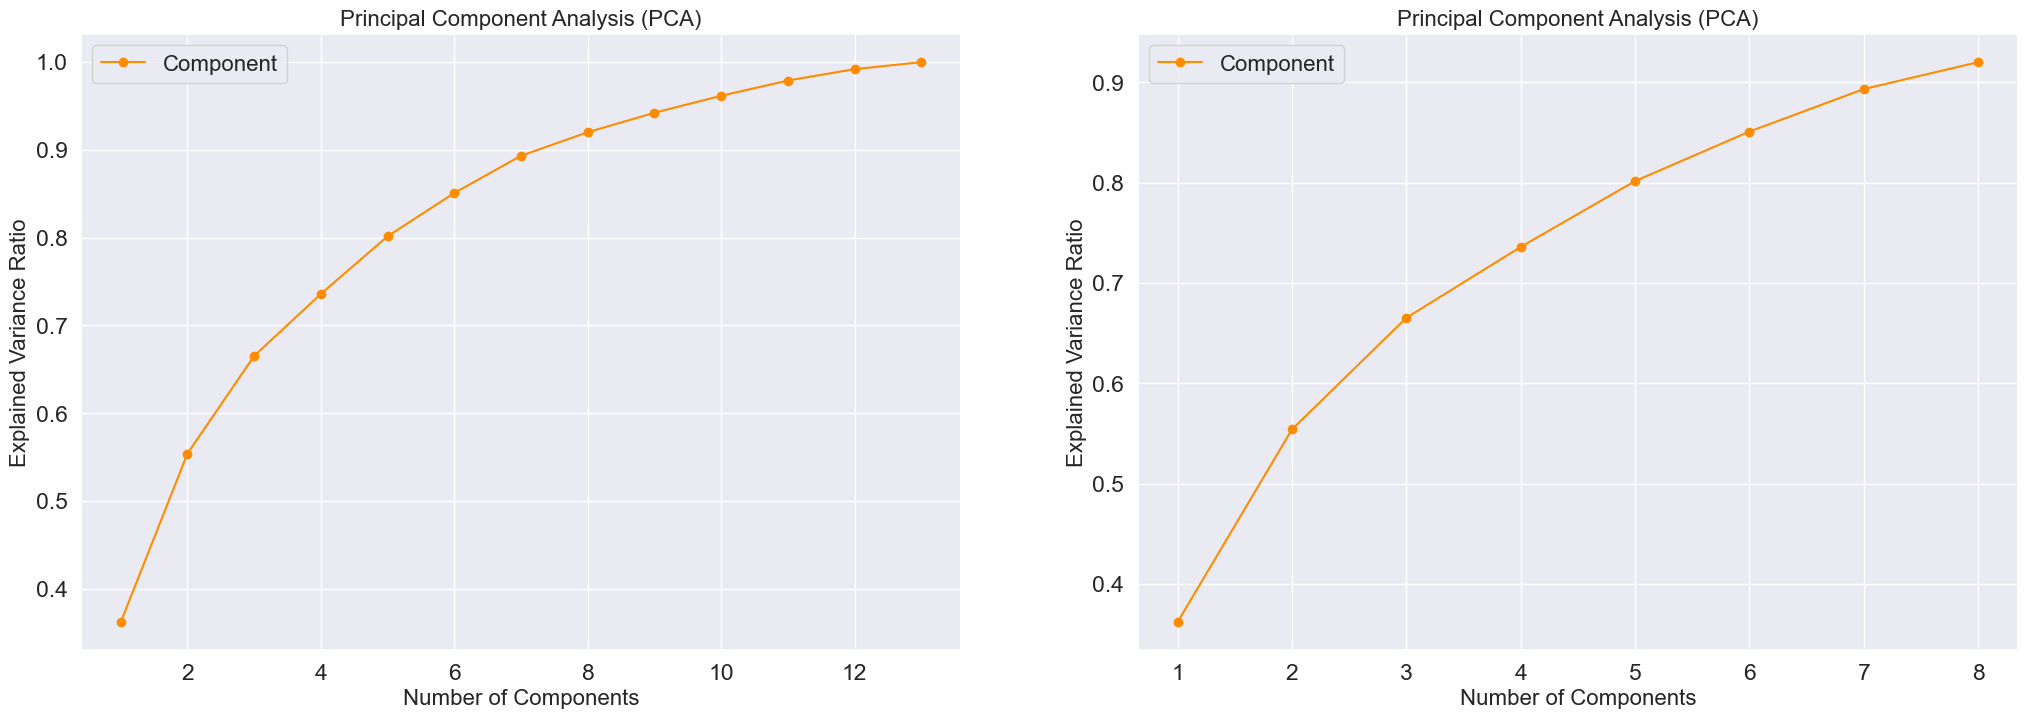

In [6]:
# Asılı olmayan dəyişənlərin eyni şkalaya salınması
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X = df)

# Prinsipyal Komponent Analiz alqoritmasının tətbiqi
pca = PCA(random_state = 42)
X_scaled_pca = pca.fit_transform(X = X_scaled)

# Prinsipyal Komponent Analiz alqoritmasına görə datasetin ümumi izah edilmə faizinin vizuallaşdırılması
plt.figure(figsize = (25, 8))
plt.subplot(1, 2, 1)
plt.plot(range(1, df.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), label = 'Component', c = 'darkorange', marker = 'o')
plt.title(label = 'Principal Component Analysis (PCA)', fontsize = 16)
plt.ylabel(ylabel = 'Explained Variance Ratio', fontsize = 16)
plt.xlabel(xlabel = 'Number of Components', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)

# Prinsipyal Komponent Analiz alqoritmasına görə datasetin ümumi izah edilmə faizinin vizuallaşdırılması
plt.subplot(1, 2, 2)
plt.plot(range(1, 9), pca.explained_variance_ratio_[:8].cumsum(), label = 'Component', c = 'darkorange', marker = 'o')
plt.title(label = 'Principal Component Analysis (PCA)', fontsize = 16)
plt.ylabel(ylabel = 'Explained Variance Ratio', fontsize = 16)
plt.xlabel(xlabel = 'Number of Components', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

In [7]:
# Prinsipyal Komponent Analiz alqoritmasının tətbiqi
pca = PCA(n_components = 8, random_state = 42)
X_scaled_pca = pca.fit_transform(X = X_scaled)

# Asılı olmayan dəyişənlərdən ibarət listin yaradılması
features = df.columns.tolist()

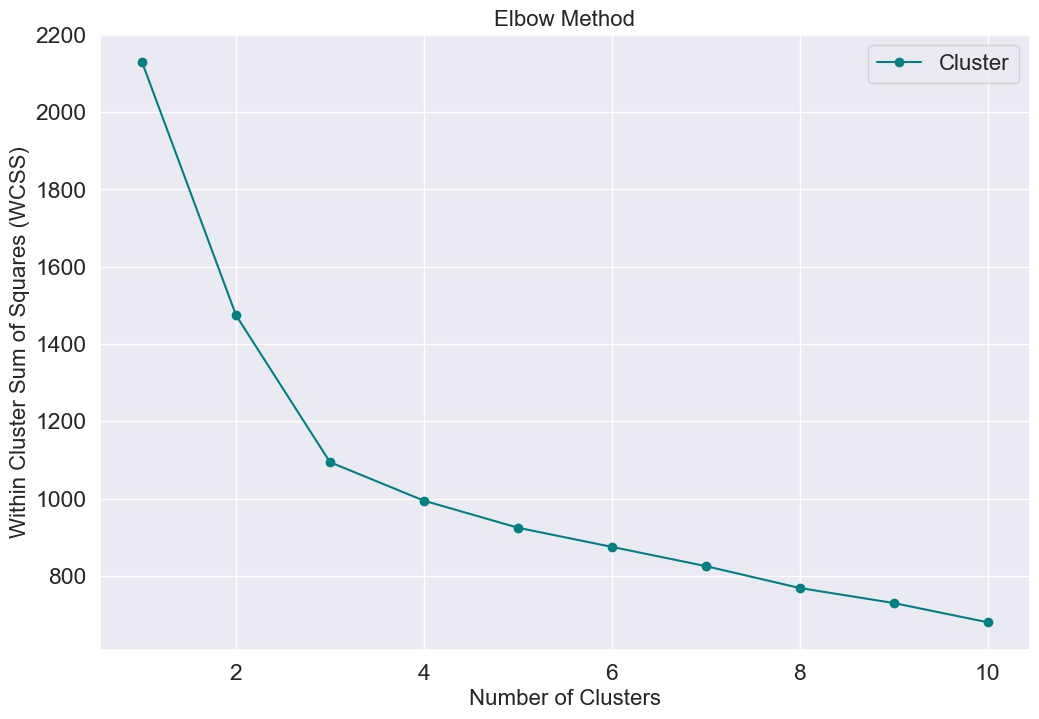

In [8]:
# Boş listin yaradılması
WCSS = []

# Döngü
for i in range(1, 11):
    # KMeans alqoritmasından ibarət modelin qurulması
    model = KMeans(n_clusters = i, random_state = 42)
    
    # Asılı olmayan dəyişənlərin modelə verilməsi
    model.fit(X = X_scaled_pca)
    
    # İnerşiyanın hesablanması
    inertia = model.inertia_
    
    # İnerşiyanın listə salınması
    WCSS.append(inertia)

# Dirsək metodunun vizuallaşdırılması
plt.plot(range(1, 11), WCSS, label = 'Cluster', marker = 'o', c = 'teal')
plt.title(label = 'Elbow Method', fontsize = 16)
plt.ylabel(ylabel = 'Within Cluster Sum of Squares (WCSS)', fontsize = 16)
plt.xlabel(xlabel = 'Number of Clusters', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

In [9]:
# build_pipeline adında funksiyanın yaradılması
def build_pipeline(data_frame = None, flat_clustering = True, imputation_strategy = None, n_components = None, n_clusters = None):
    if flat_clustering:
        # Boru modelin qurulması
        pipe = Pipeline(steps = [('imputer', SimpleImputer(strategy = imputation_strategy)), 
                                 ('scaler', StandardScaler()), 
                                 ('pca', PCA(n_components = n_components, random_state = 42)), 
                                 ('model', KMeans(n_clusters = n_clusters, random_state = 42))])

        # Boru modelə datasetin verilməsi
        pipe.fit(X = data_frame[features])
        
        # Borunun geri qaytarılması
        return pipe
    else:
        # Boru modelin qurulması
        pipe = Pipeline(steps = [('imputer', SimpleImputer(strategy = imputation_strategy)), 
                                 ('scaler', StandardScaler()), 
                                 ('pca', PCA(n_components = n_components, random_state = 42)), 
                                 ('model', AgglomerativeClustering(n_clusters = n_clusters))])

        # Boru model vasitəsi ilə klasterlərin proqnozlaşdırıması
        clusters = pipe.fit_predict(X = data_frame[features])
    
        # Borunun və proqnozlaşdırılan klasterlərin geri qaytarılması
        return pipe, clusters

In [10]:
# Funksiyanın çağırılması
kmeans = build_pipeline(data_frame = df,
                        imputation_strategy = 'median',
                        n_components = 8,
                        n_clusters = 3)

# Boru modelin arxitekturasının göstərilməsi
kmeans

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=8, random_state=42)),
                ('model', KMeans(n_clusters=3, random_state=42))])

In [11]:
# Boru modelin proqnozlarının flat_cluster sütununa təyin olunması
df['flat_cluster'] = kmeans.predict(X = df)

# İlk beş sətirin göstərilməsi
df.head()

,alcohol,malic_acid,ash,ash_alcanity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline,flat_cluster
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,2
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,2
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,2
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,2
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,2


In [12]:
# Funksiyanın çağırılması
agglomerative, clusters = build_pipeline(data_frame = df,
                                         flat_clustering = False,
                                         imputation_strategy = 'median',
                                         n_components = 8,
                                         n_clusters = 3)

# Boru modelin arxitekturasının göstərilməsi
agglomerative

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=8, random_state=42)),
                ('model', AgglomerativeClustering(n_clusters=3))])

In [13]:
# Boru modelin proqnozlarının hierarchical_cluster sütununa təyin olunması
df['hierarchical_cluster'] = clusters

# İlk beş sətirin göstərilməsi
df.head()

,alcohol,malic_acid,ash,ash_alcanity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline,flat_cluster,hierarchical_cluster
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,2,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,2,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,2,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,2,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,2,0


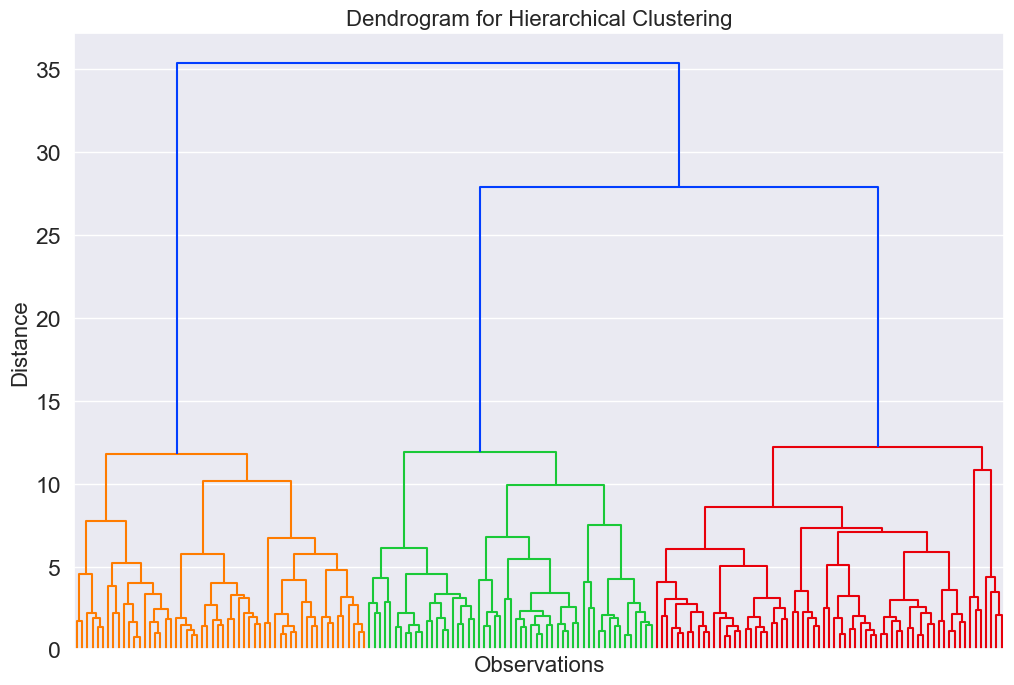

In [14]:
# İyerarxik klasterinq alqoritmasının Dendroqram ilə vizuallaşdırılması
dendrogram(Z = linkage(y = agglomerative[:-1].transform(X = df[features]), method = 'ward'), no_labels = True)
plt.title(label = 'Dendrogram for Hierarchical Clustering', fontsize = 16)
plt.xlabel(xlabel = 'Observations', fontsize = 16)
plt.ylabel(ylabel = 'Distance', fontsize = 16)
plt.show()

In [15]:
# Modelin pickle faylı kimi yaddaşa yazılması
with open(file = 'kmeans_model.pickle', mode = 'wb') as pickled_model:
    pickle.dump(obj = kmeans, file = pickled_model)